# Global indicator project - Phoenix, Arizona

## Create population analysis - with the GHSL Landsat population datasets

This notebook describes the process to import population raster by 250m grid cell (download from [GHSL web](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop)), clip the raster data based on study region boundary. Then the raster data is transformed into shapely polygon and geodataframe in order to conduct GIS functionalities with sample point stats.

The idea is to take average of sample point stats to 250m grid, and visualize the indicator result (eg. walkability) in grid cell.  

Other notes from Carl: 

- we could use 250m grid cells (restricted to urban regions corresponding to our cities) as our 'universal unit' across all cities: ie. take averages of samples within these areas
- we need to discuss: is population density fine to substitute for dwelling density in walkability formula? We take a z-score in any case, so it becomes an abstract relative measure of much the same thing i think?
- we could visualise final results using population weighted 1km grids (the [Walk and the City example](http://geochoros.survey.ntua.gr/walkandthecity/walkability) shows Walkability spatial distribution across a large number of countries provides a great example of this approach): this mode of visualisation could be adopted for other indicators (eg. estimated percent of population with access to public open space).

Data info: GHS-POP, epoch: 2015, resolution: 250 m, coordinate system: Mollweide  
Data source: https://ghsl.jrc.ec.europa.eu/download.php?ds=pop  
Map example: http://geochoros.survey.ntua.gr/walkandthecity/walkability  
Method note: https://github.com/gboeing/global-indicators/pull/4 


In [1]:
# Libraries used for OSMnx analyses and output
import pprint
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio import features

import networkx as nx
import time 
import os
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import json

from shapely.geometry import shape,Point, LineString, Polygon

ox.config(use_cache=True, log_console=True)


In [56]:
place = 'phoenix' 

region = 'Arizona, USA' # study region name

studyregion = 'Phoenix, Arizona, USA'

suffix = '_201905'

# configure filenames to save/load datasets
OSM_folder = '../data/OSM'
shap_filepath = '../data/Maricopa_County/MC_Boundary.shp'
admindata_filepath = '../data/Maricopa_County/BlockGroup_Data.shp'
shapefile_path = '../data/OSM/phoenix_walk_201905/phoenix_walk_201905.shp'

sample_points_filepath = '../data/OSM/phoenix_sample_points_201905/phoenix_sample_points_201905.shp'
sample_points_stats_filepath = '../data/OSM/phoenix_sample_points_stats_201905.csv'

population_raster_file = '../data/Population/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_7_4/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_7_4.tif'

## 1. Load study region buffered boundary

In [3]:
boundary_filepath = '../data/Maricopa_County/MC_Boundary.shp'

clipping_boundary = gpd.GeoDataFrame.from_file(boundary_filepath)
clipping_boundary.crs

{'init': 'epsg:3742'}

## 2. load and clip GHSL population raster data

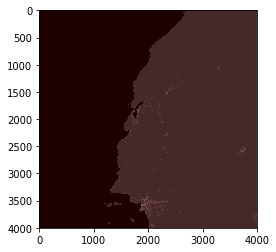

In [4]:
# load raster
raster_pop = rasterio.open(population_raster_file) 
pyplot.imshow(raster_pop.read(1), cmap='pink')
pyplot.show()

In [5]:
raster_pop.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -200.0,
 'width': 4000,
 'height': 4000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
 'transform': Affine(250.0, 0.0, -11041000.0,
        0.0, -250.0, 5000000.0)}

In [6]:
with rasterio.open(population_raster_file) as full_raster:
    # set pop_vector to match crs of input raster
    # the above works as tested (raster is epsg 4326)
    # in theory, works if epsg is otherwise detectable in rasterio
    clipping_boundary.to_crs(raster_pop.crs,inplace=True)
    coords = [json.loads(clipping_boundary.to_json())['features'][0]['geometry']]
    out_img, out_transform = mask(full_raster, coords, crop=True)
    out_meta = full_raster.meta.copy()
    out_meta.update({
                    "driver": "GTiff",
                    "height": out_img.shape[1],
                    "width":  out_img.shape[2],
                    "transform": out_transform
                    }) 
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -200.0,
 'width': 718,
 'height': 456,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
 'transform': Affine(250.0, 0.0, -10220500.0,
        0.0, -250.0, 4114000.0)}

In [7]:
population_raster_clipped =  '../data/Population/{}_clipped_{}.tif'.format('population', studyregion)
with rasterio.open(population_raster_clipped, "w", **out_meta) as dest:
    dest.write(out_img) 

In [8]:
def reproject_raster(inpath, outpath, new_crs):
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    dst_crs = new_crs # CRS for web meractor 
    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [9]:
# reproject and save the re-projected clipped raster
# need to discuss projection for study regions
population_raster_projected = '../data/Population/{}_clipped_{}.tif'.format('population_proj', studyregion)
srid = '3742'

reproject_raster(inpath = population_raster_clipped, 
              outpath = population_raster_projected, 
              new_crs = 'EPSG:{}'.format(srid))   


## 3. Convert population raster to polygon features and geodataframe
https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

In [10]:
raster_pop = rasterio.open(population_raster_projected)    
nodata = raster_pop.nodata

In [11]:
raster_pop.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -200.0,
 'width': 777,
 'height': 346,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3742'),
 'transform': Affine(332.99295092617854, 0.0, 168514.0531079576,
        0.0, -332.99295092617854, 3773429.3713804027)}

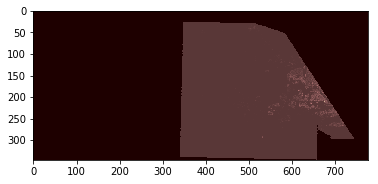

In [12]:
pyplot.imshow(raster_pop.read(1), cmap='pink')
pyplot.show()

In [13]:
# extract shapes of pop raster features 
shapes = features.shapes(raster_pop.read(), transform=raster_pop.transform)
pprint.pprint(next(shapes))

({'coordinates': [[(334344.5426691945, 3763439.5828526174),
                   (334344.5426691945, 3763106.5899016913),
                   (334677.5356201207, 3763106.5899016913),
                   (334677.5356201207, 3763439.5828526174),
                   (334344.5426691945, 3763439.5828526174)]],
  'type': 'Polygon'},
 10.378678321838379)


In [15]:
#The result is a generator of GeoJSON features
from rasterio.features import shapes
mask = None

with rasterio.open(population_raster_projected) as src:
    image = src.read(1) # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, transform=src.transform)))

In [16]:
# That you can transform into shapely geometries
from shapely.geometry import shape
geoms = list(results)
print(shape(geoms[0]['geometry']))

POLYGON ((334344.5426691945 3763439.582852617, 334344.5426691945 3763106.589901691, 334677.5356201207 3763106.589901691, 334677.5356201207 3763439.582852617, 334344.5426691945 3763439.582852617))


In [17]:
# Create geopandas Dataframe and enable easy to use functionalities of spatial join, plotting, ESRI shapefile etc.
gpd_polygonized_raster = gpd.GeoDataFrame.from_features(geoms)

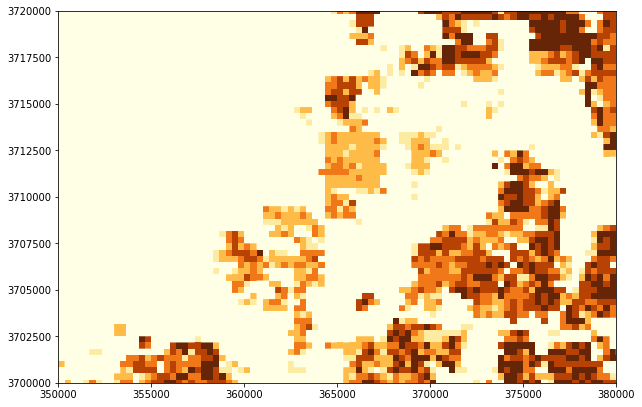

In [39]:
# plot the population gird values
values = gpd_polygonized_raster.dropna(subset=['raster_val'])
ax = values.plot(column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(10,10))
ax.set_xlim(350000, 380000)
ax.set_ylim(3700000, 3720000)

plt.show()
  

- convert 250m grid raster to polygon, and geodataframe. shapely geometry and geodataframe. 

## 4. Associate population raster/polygon with sample points stats


In [54]:
#load sample point gdf with stats
sample_points = gpd.GeoDataFrame.from_file(sample_points_filepath)

# load edge shapefile
edges_gdf = gpd.GeoDataFrame.from_file(shapefile_path)

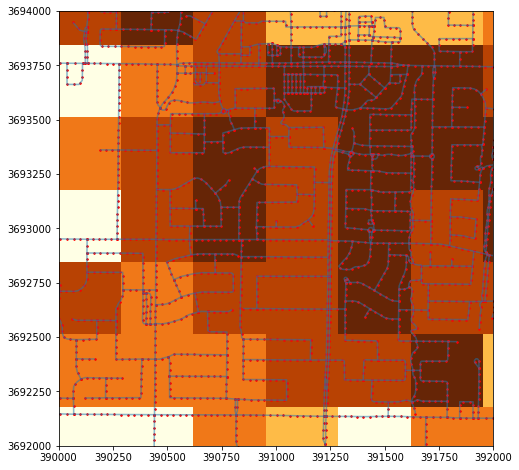

In [58]:
#sample point with the population grid polygon
fig, ax = plt.subplots(figsize=(8, 8))
ax = gpd_polygonized_raster.plot(ax=ax, column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(10,10))
ax = sample_points.plot(ax=ax, color='red', markersize=1.5)
ax = edges_gdf.plot(ax=ax, alpha=0.3)
ax.set_xlim(390000, 392000)
ax.set_ylim(3692000, 3694000)

#ax.set_xlim(410750, 411200)
#ax.set_ylim(3687500, 3688000)
plt.show()

 **Next steps:**

- evaluate local street connectivity for sample points  
- evaluate a land use mix or proxy score (e.g. 'daily living' access to amenities) for sample points  
- take average of these to 250m grid. (are we averaging all sample points within each grid cell? Or we take sample of the sample points within the the cell and take the average?)
- Then we have population density (pop/area in hectares of 250m grid cell), street connectivity (average connectivity per square km of local road networks in grid cell), and daily living access (average score from 0 to 3 for access to daily living amenities in grid cell) 
- Calculate respective z-scores of pop (or dwelling) density, street connectivity and daily living  
- Sum z-scores for a walkability index calculated for 250m grid cells